In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
data = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(data))
data.head()

544


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [3]:
hlp.pandas.numeric_summary(data)

---

# Model - Linear

In [4]:
data_adults = data[data.age >= 18]  # only adults

x_bar = data_adults.weight.mean()
with pm.Model() as model_linear:
    # this is so we can update the data to make out of sample predictions
    X = pm.MutableData("X", data_adults.weight.values)
    y = pm.MutableData("y", data_adults.height.values)

    a = pm.Normal("a", mu=178, sigma=20)
    # lognormal means there will be >0 relationship between b (weight) and height
    # i.e. we are explicitly stating that negative relationships don't make sense
    # b = pm.Normal("b", mu=0, sigma=20)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # mu = a + np.exp(b) * (d2.weight.values - xbar)
    # mu = a + np.exp(b) * (np.zeros(len(d2)) - d2.weight.mean())
    mu = a + b * (X - x_bar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y)
    # trace_4_3b = pm.sample(1000, tune=1000)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, b, height, sigma]


# Prior Checks

In [5]:
prior_samples_b = ph.get_prior_samples(idata_prior, variable_name='b').flatten()

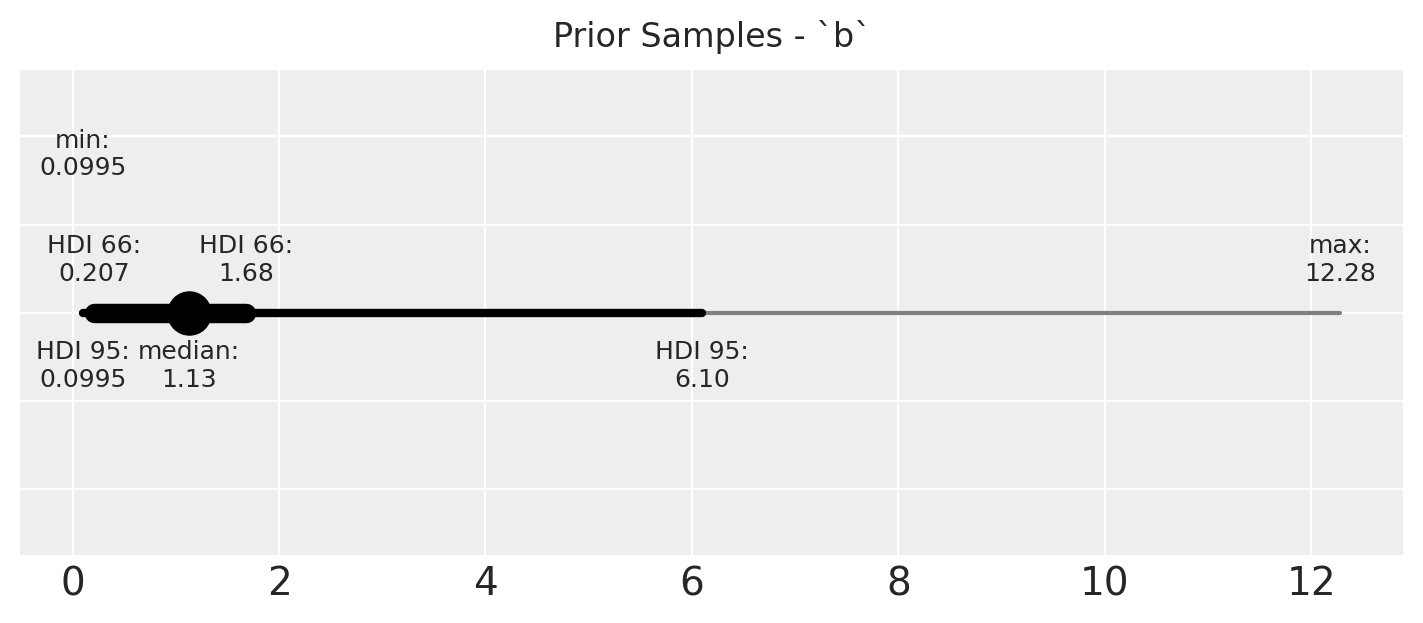

In [6]:
from helpsk.string import format_number

sim_min, sim_median, sim_max = np.quantile(prior_samples_b, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(prior_samples_b, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(prior_samples_b, hdi_prob=0.66)

def plot_text(x, label, above=True, mult=1):
    y = 0.012
    y *= mult
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min', mult=3)
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
# plt.xlim((115, 195))
plt.suptitle("Prior Samples - `b`");

In [7]:
prior_samples_target = ph.get_prior_samples(idata_prior).flatten()

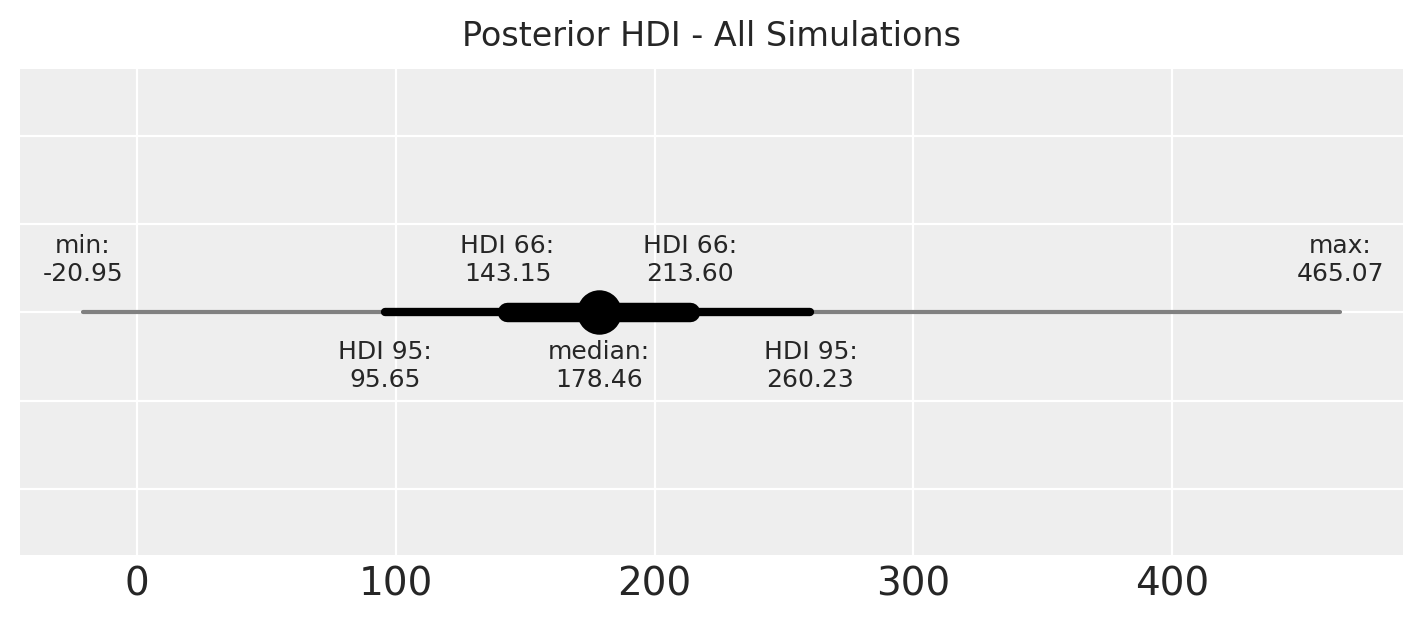

In [8]:
from helpsk.string import format_number

sim_min, sim_median, sim_max = np.quantile(prior_samples_target, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(prior_samples_target, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(prior_samples_target, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
# plt.xlim((115, 195))
plt.suptitle("Posterior HDI - All Simulations");

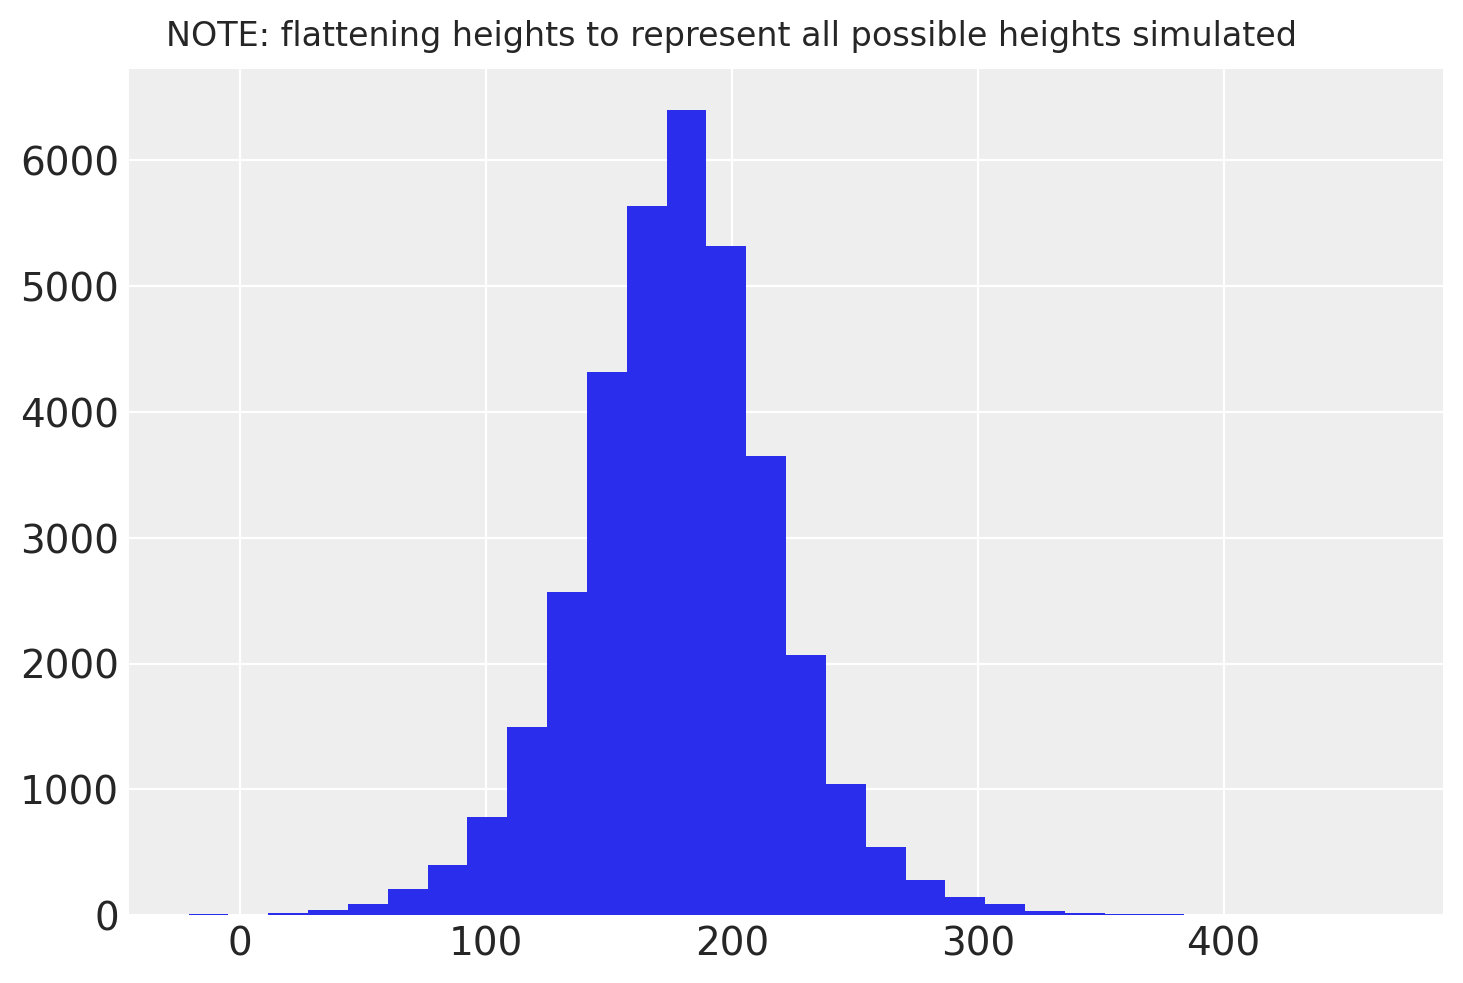

In [9]:
plt.hist(prior_samples_target, bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

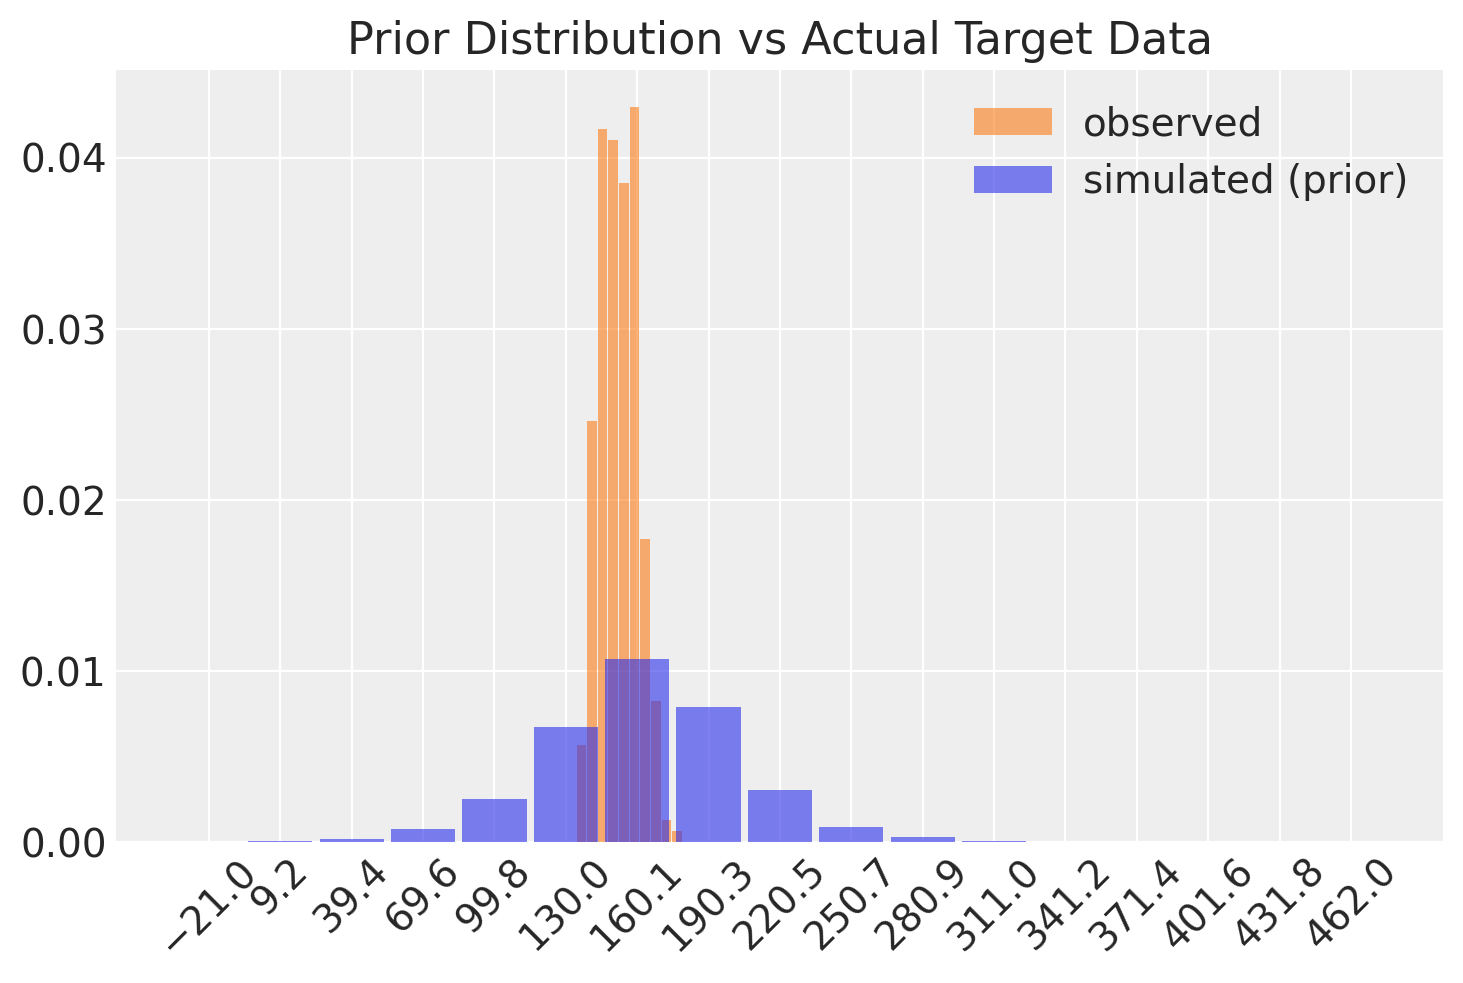

In [10]:
az.plot_dist(
    data_adults['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [11]:
with model_linear:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


## Model Parameters

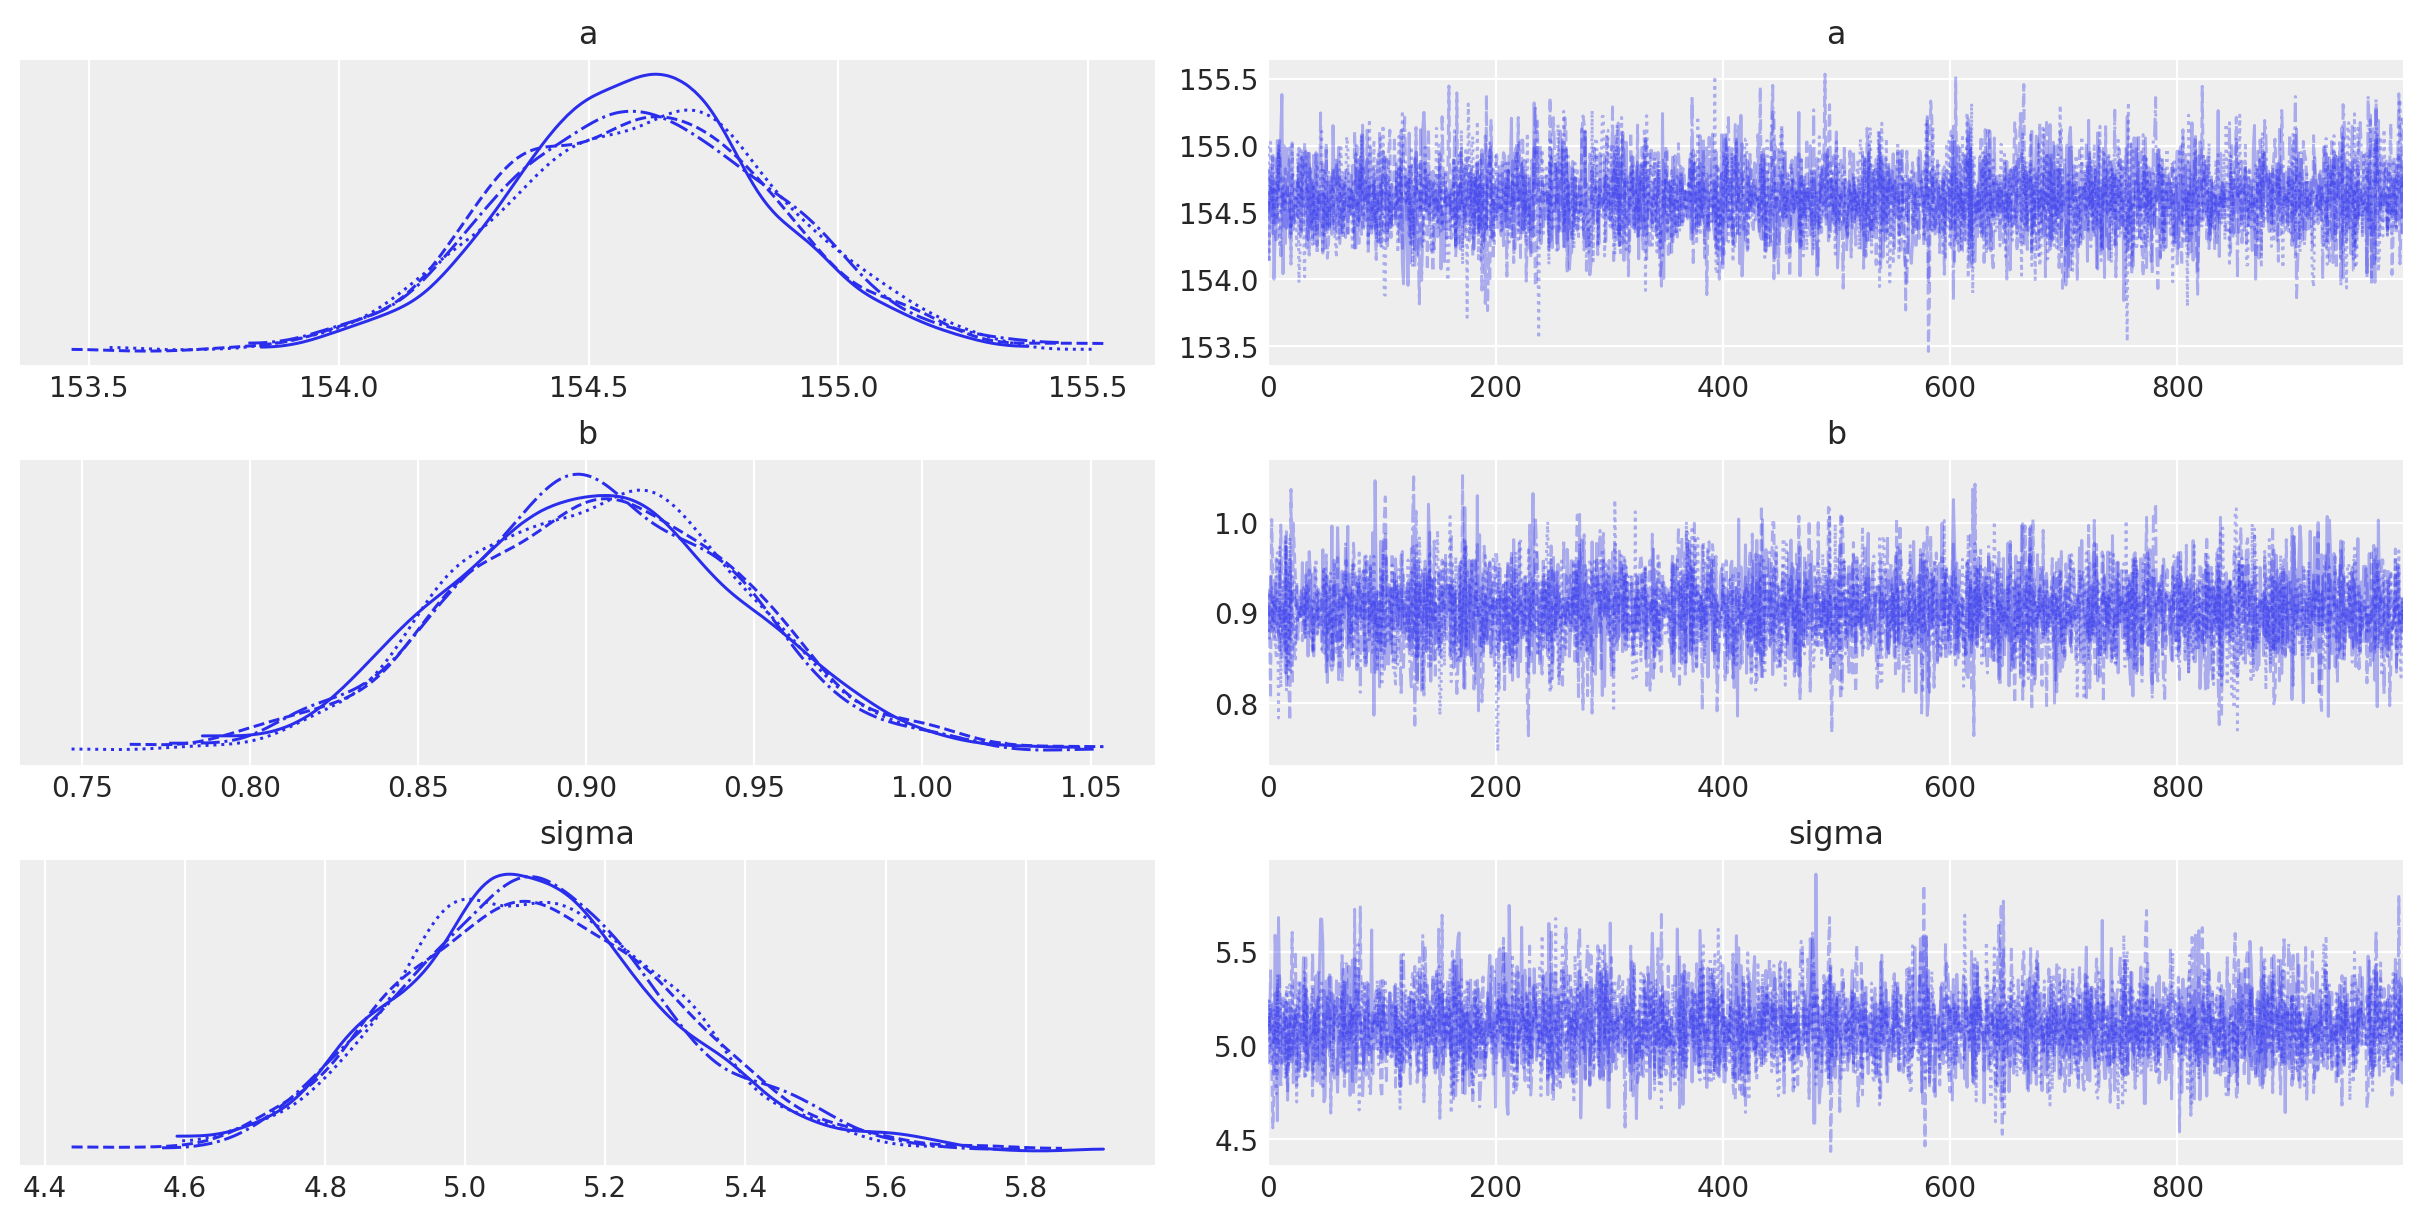

In [12]:
az.plot_trace(idata_posterior);

In [13]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a      154.608  0.273  154.109  155.137
b        0.903  0.043    0.819    0.980
sigma    5.102  0.192    4.737    5.461

### Comparison w/ `statsmodels` linear regression

In [14]:
import statsmodels.api as sm

ols_x = data_adults[['weight']] - data_adults['weight'].mean()
ols_y = data_adults['height']

ols_x = sm.add_constant(ols_x)
ols_model = sm.OLS(ols_y, ols_x).fit() 
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           4.68e-66
Time:                        21:42:52   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        154.5971      0.271    570.253      0.0

In [15]:
import plotly_express as px

ols_predictions = ols_model.predict(ols_x)
temp = data_adults.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights (OLS)"] = ols_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights (OLS)",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction (OLS)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(135, 180), y=np.arange(135, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


---

## Target Variable

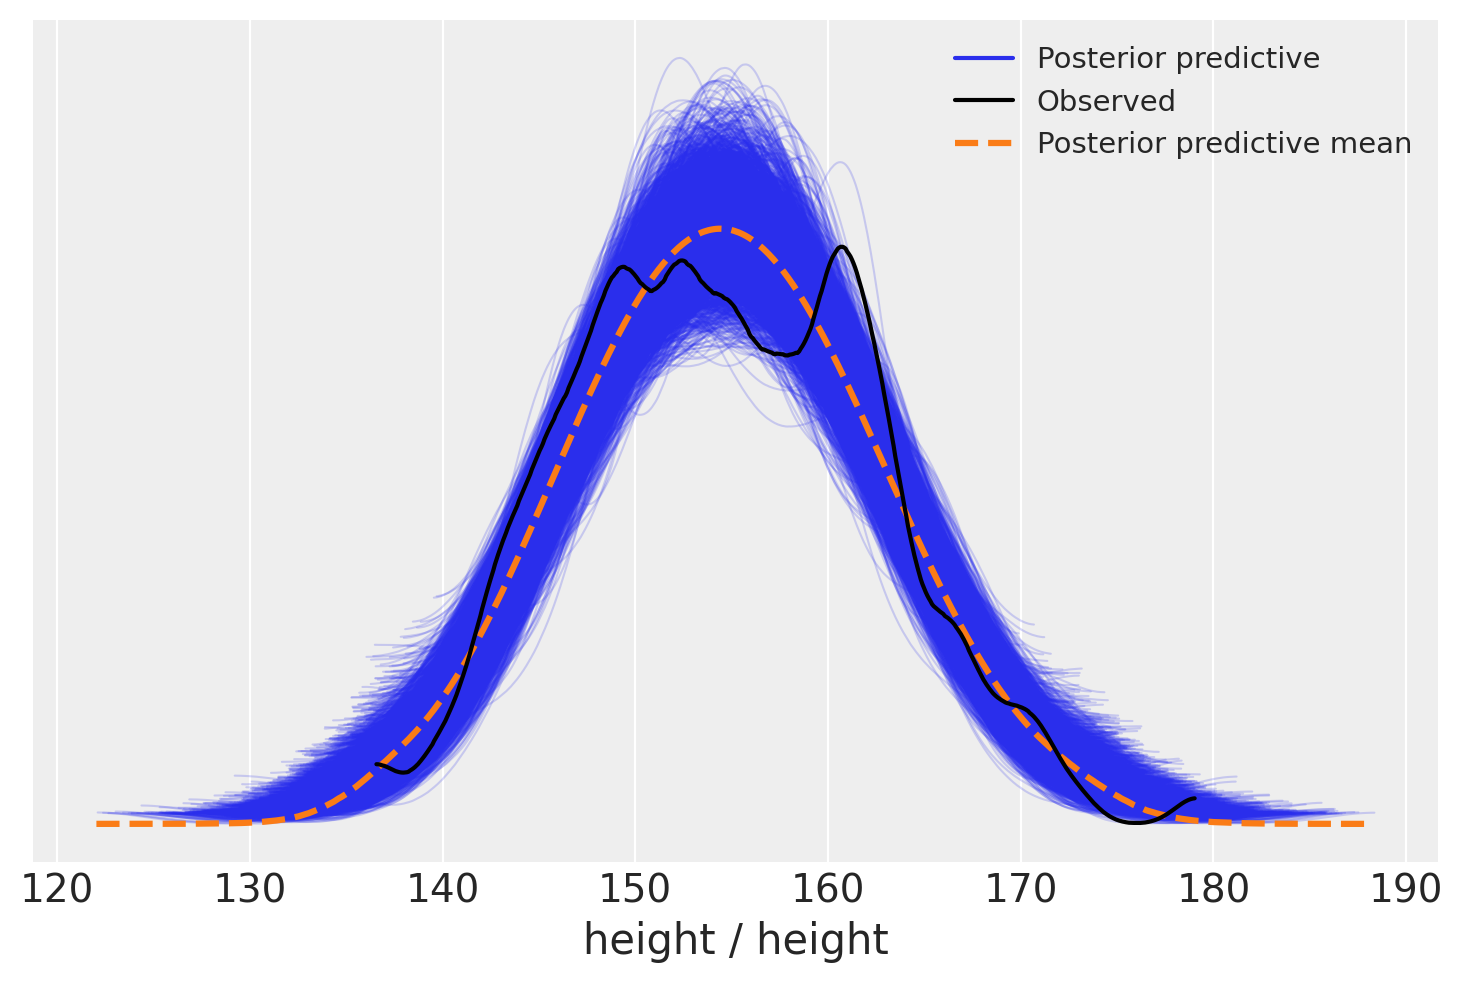

In [16]:
az.plot_ppc(idata_predictive);

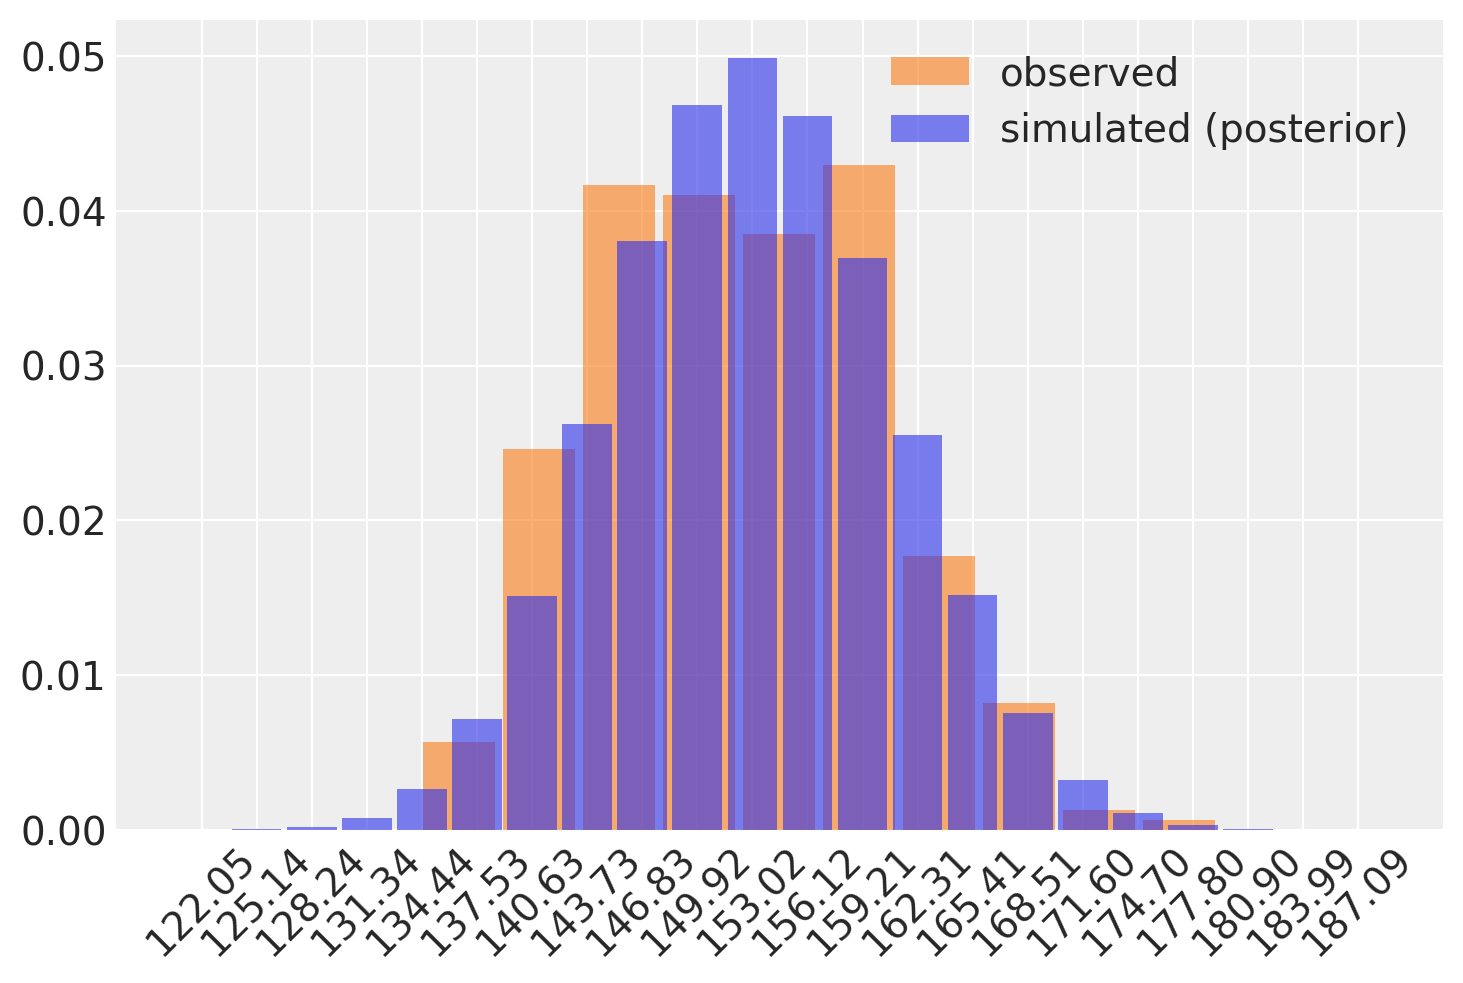

In [17]:

az.plot_dist(
    data_adults['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [18]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(352, 4000)

In [19]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

122.0471527846058
188.40680812450321


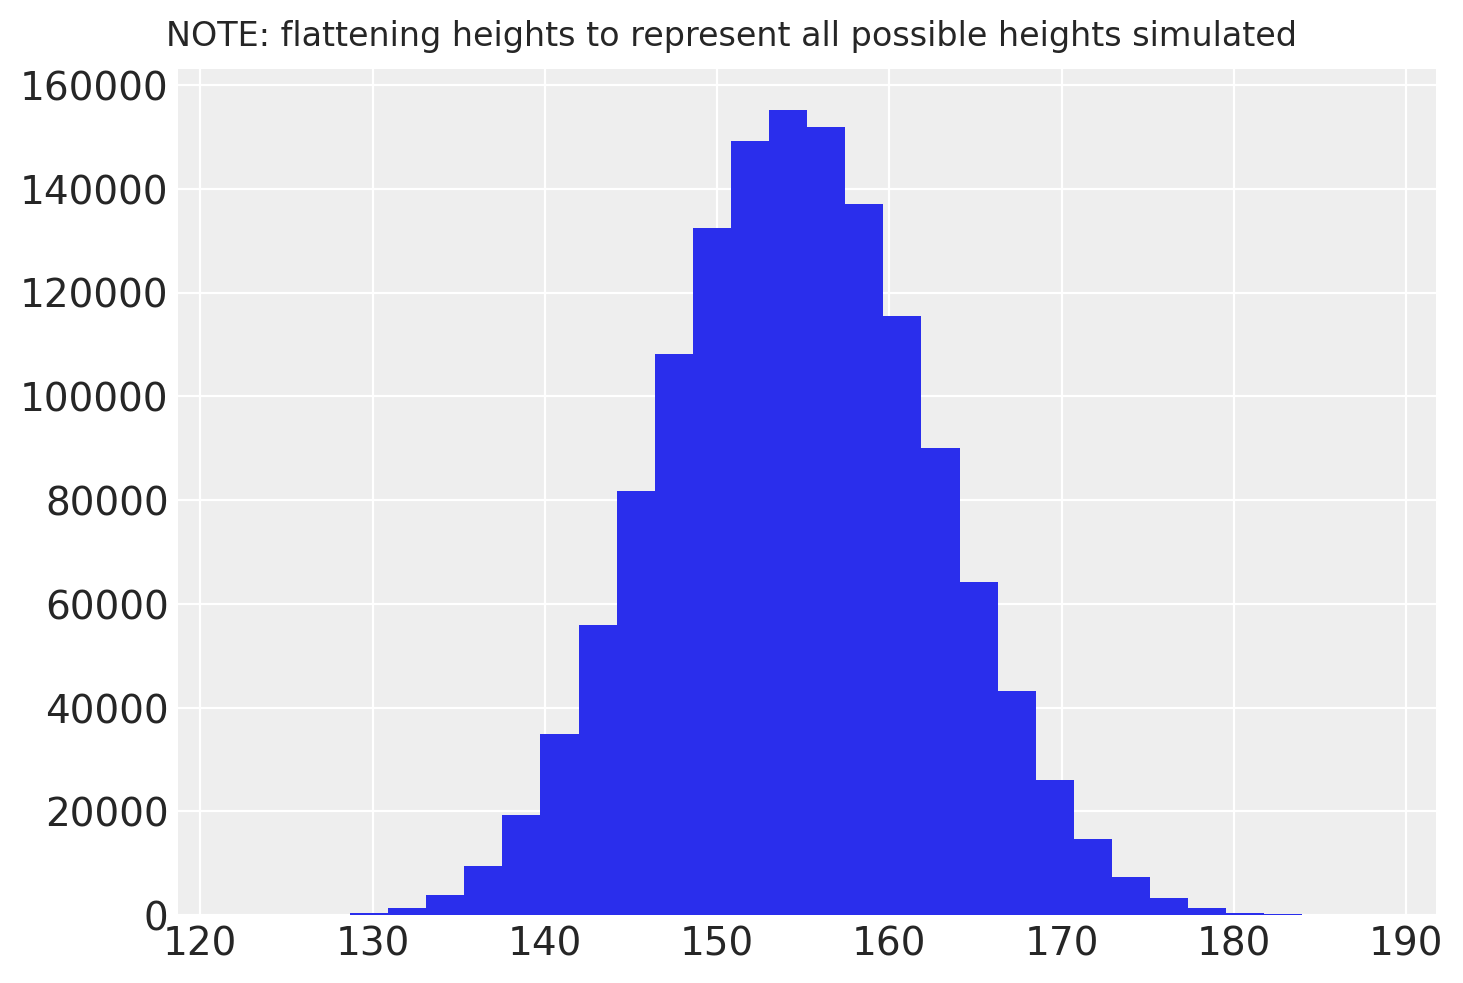

In [20]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [21]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

142.09727142008188
170.8848745843694


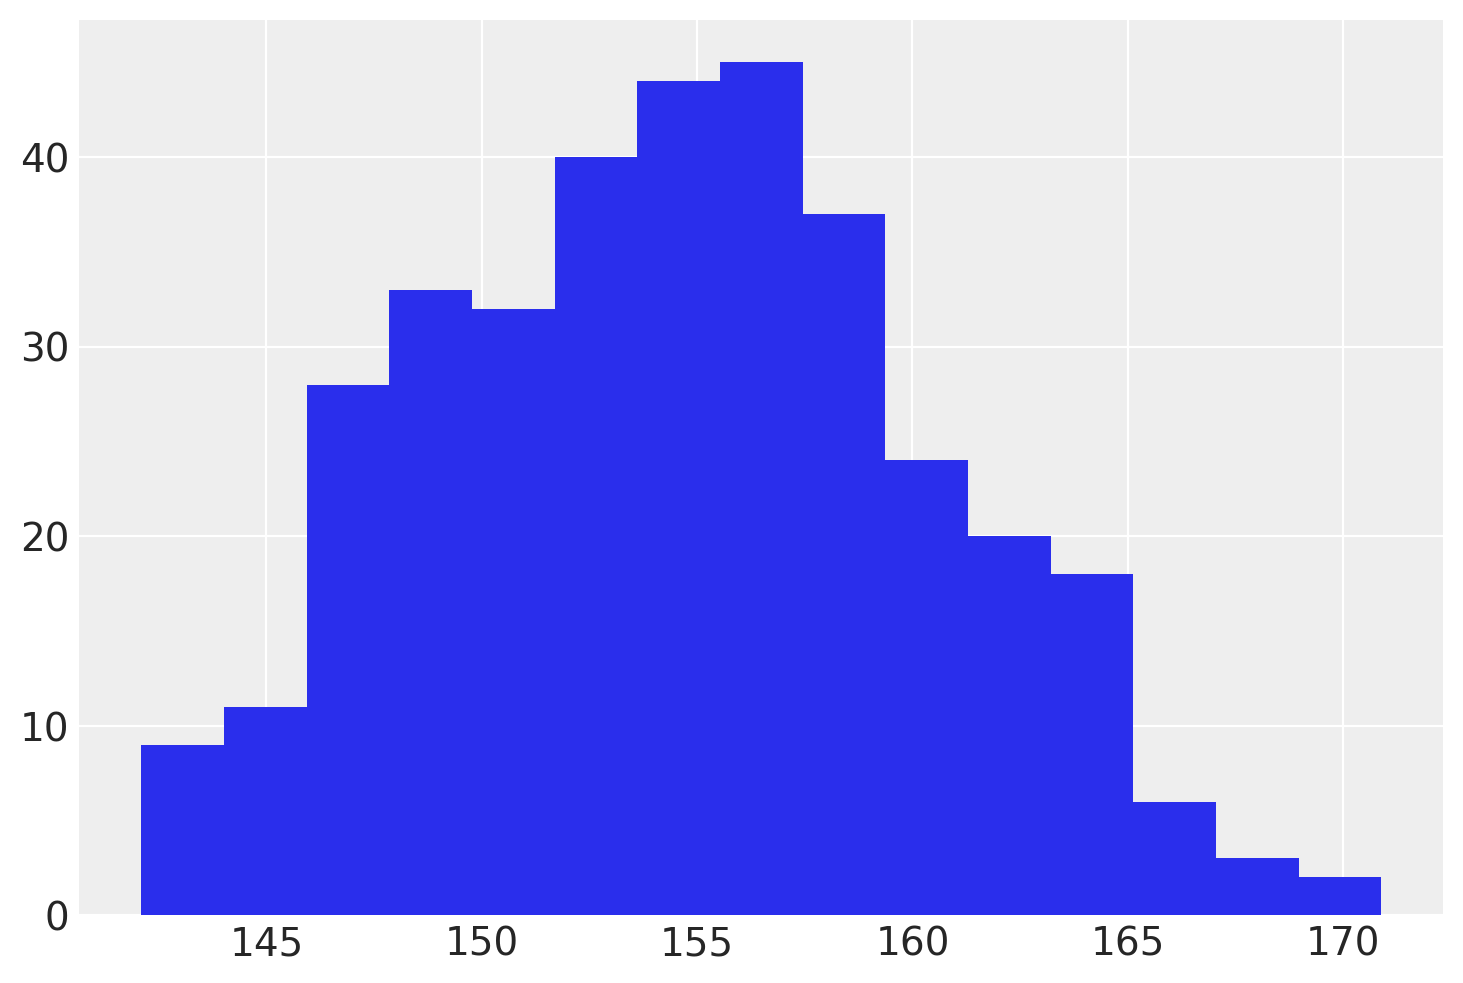

In [22]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [23]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a      154.608  0.273  154.109  155.137
b        0.903  0.043    0.819    0.980
sigma    5.102  0.192    4.737    5.461

In [24]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning:

Selecting first found group: posterior_predictive



mean     sd   hdi_3%  hdi_97%
height[0]    157.263  5.100  147.103  166.340
height[1]    146.836  5.146  137.325  156.715
height[2]    142.770  5.213  133.383  152.766
height[3]    161.995  5.144  152.337  171.594
height[4]    151.151  5.106  142.305  161.561
...              ...    ...      ...      ...
height[347]  156.428  5.002  147.385  166.107
height[348]  144.995  5.173  135.187  154.908
height[349]  161.099  5.001  151.591  170.147
height[350]  162.856  5.020  153.153  171.953
height[351]  161.340  5.121  151.045  170.244

[352 rows x 4 columns]

In [25]:
posterior_target_samples = ph.get_posterior_samples(idata_predictive)
posterior_target_point_predictions = np.median(posterior_target_samples, axis=1)
assert posterior_target_samples.shape[0] == len(posterior_target_point_predictions)

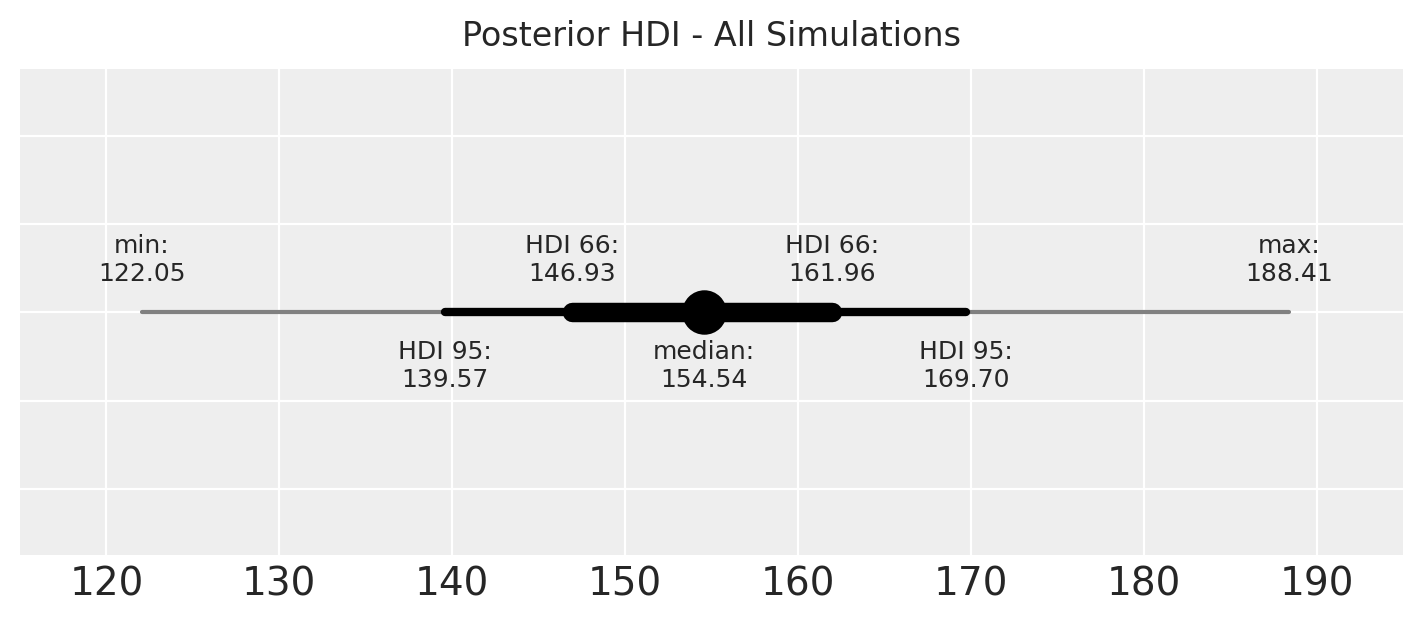

In [26]:
from helpsk.string import format_number

samples_flattened = posterior_target_samples.flatten()

sim_min, sim_median, sim_max = np.quantile(samples_flattened, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
plt.xlim((115, 195))
plt.suptitle("Posterior HDI - All Simulations");

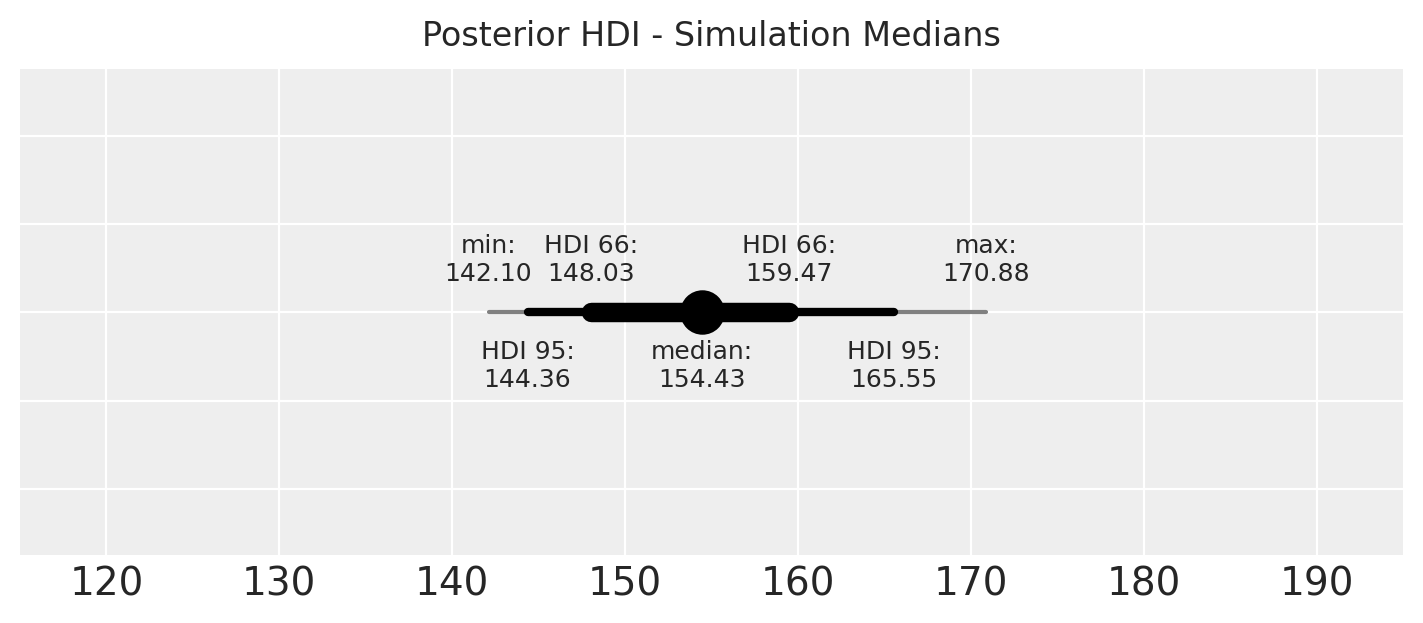

In [27]:
from helpsk.string import format_number

sim_min, sim_median, sim_max = np.quantile(posterior_target_point_predictions, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
plt.xlim((115, 195))
fig.set_size_inches(w=7, h=3)
plt.suptitle("Posterior HDI - Simulation Medians");

## Actual vs Predicted

In [28]:
import plotly_express as px

temp = data_adults.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights"] = posterior_target_point_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(135, 180), y=np.arange(135, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


## Residuals

In [29]:
import plotly_express as px

temp = data_adults.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Residuals"] = posterior_target_point_predictions - temp['Actual Heights']

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Residuals",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Residual (Predicted - Actual)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)
fig.add_hline(y=0, line_width=3, line_color="red")
fig


---

# New Predictions

In [30]:
x = np.arange(30, 64)
prediction_sims = ph.posterior_predict(
    model=model_linear,
    idata_posterior=idata_posterior,
    data=x
)
prediction_sims.shape

Sampling: [height]


(34, 4000)

Text(0.5, 0.98, 'Predictions/Simulations vs Actual')

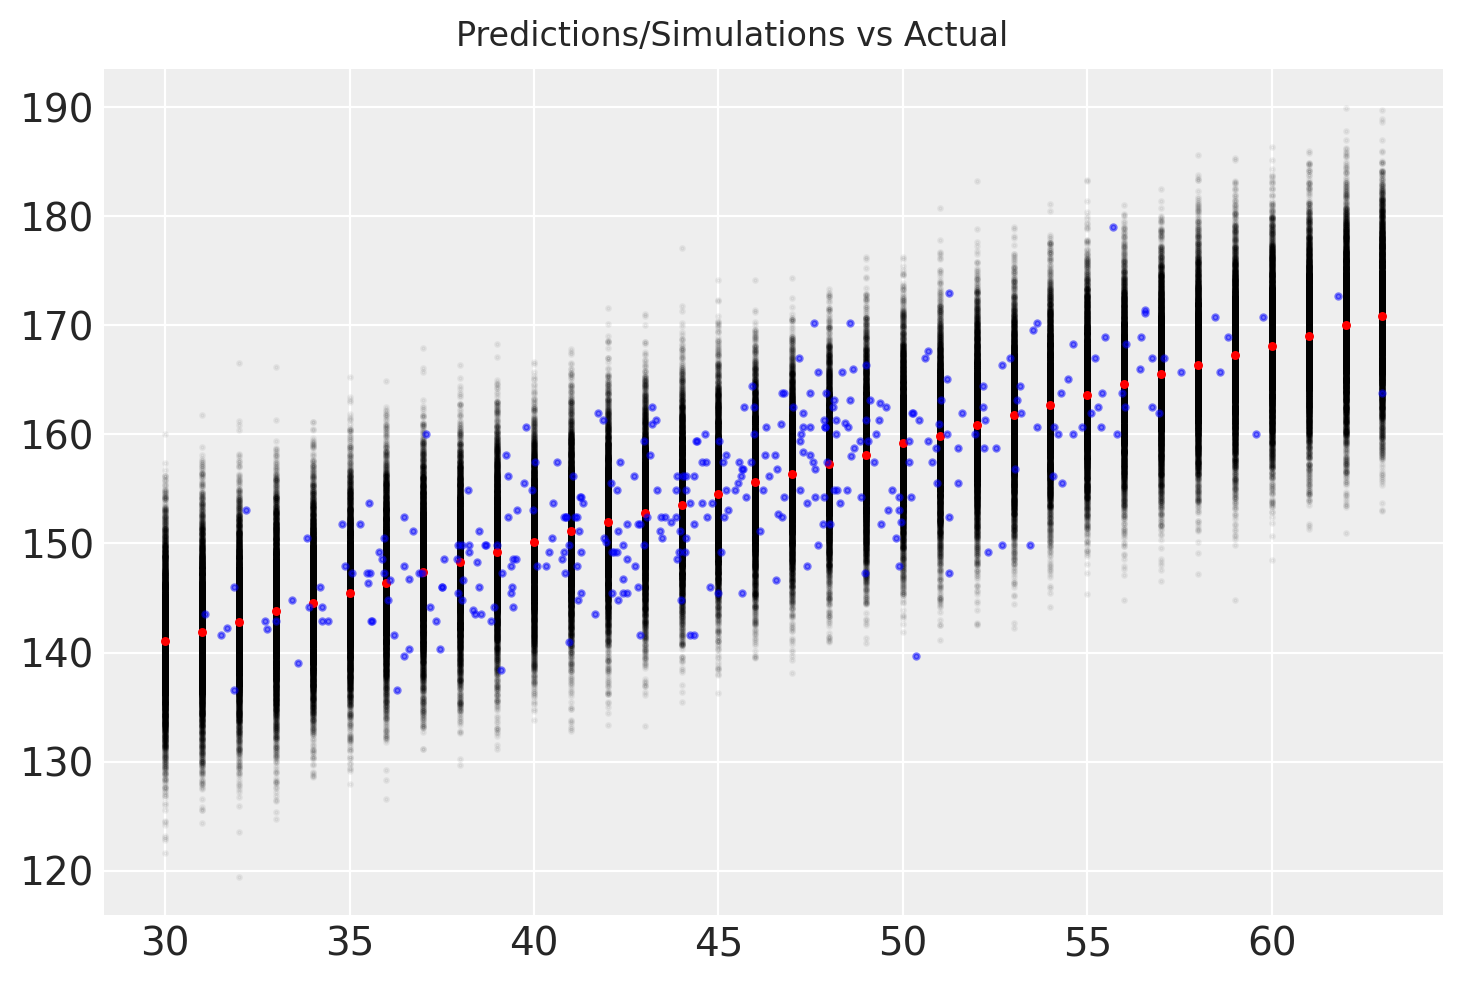

In [31]:
for index, value in enumerate(x):
    plt.scatter(
        np.repeat(value, prediction_sims.shape[1]),
        prediction_sims[index, :],
        color='black', alpha=0.05, s=2
    )
    plt.scatter(
        value,
        np.median(prediction_sims[index, :]),
        color='red', alpha=1, s=5,
    )
plt.scatter(
    data_adults.weight,
    data_adults.height,
    color='blue', alpha=0.5, s=4
);
plt.suptitle('Predictions/Simulations vs Actual')

Text(0.5, 0.98, 'Predictions/Simulations vs Actual')

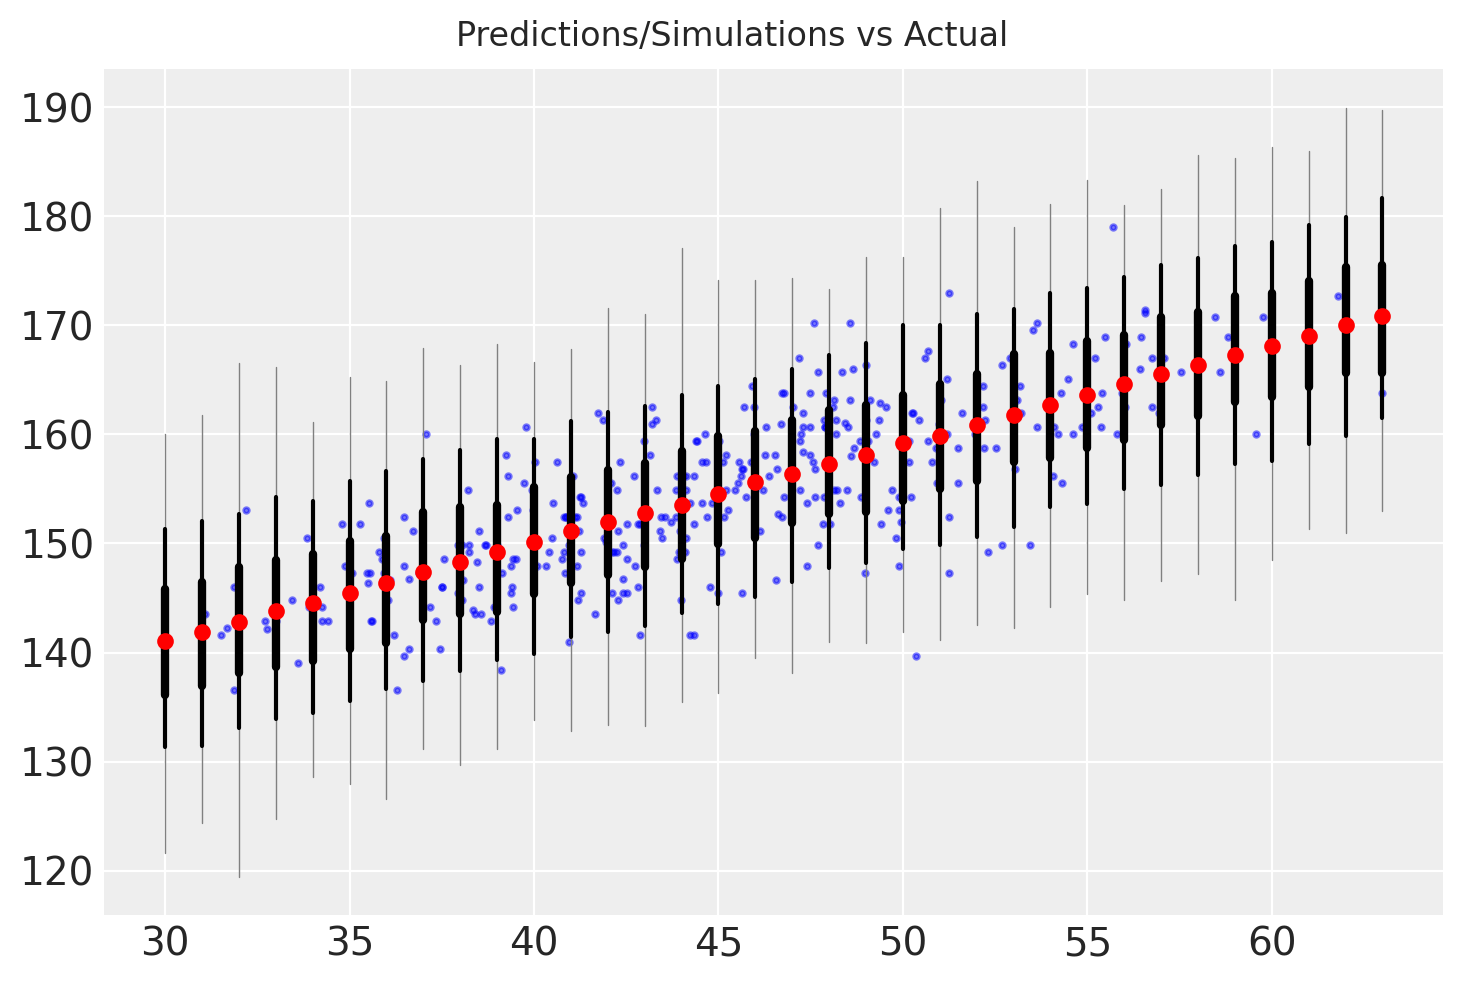

In [32]:
from helpsk.string import format_number

for index, value in enumerate(x):
    sims = prediction_sims[index, :]
    sim_min, sim_median, sim_max = np.quantile(sims, q=[0, 0.5, 1])
    sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(sims, hdi_prob=0.95)
    sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(sims, hdi_prob=0.66)
    

    plt.plot([value, value], [sim_min, sim_max], color='gray', linewidth=0.5)
    plt.plot([value, value], [sim_95_hdi_prob_low, sim_95_hdi_prob_hi], color='black', linewidth=1.5)
    plt.plot([value, value], [sim_66_hdi_prob_low, sim_66_hdi_prob_hi], color='black', linewidth=3)
    plt.plot(value, sim_median, 'o', markersize=5, color='red')

plt.scatter(
    data_adults.weight,
    data_adults.height,
    color='blue', alpha=0.5, s=4
);
plt.suptitle('Predictions/Simulations vs Actual')

---

In [33]:
x = np.arange(30, 64)
idata_ooo_sims = ph.posterior_predict_inference(
    model=model_linear,
    idata_posterior=idata_posterior,
    data=x
)
idata_ooo_sims

Sampling: [height]


Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

/tmp/ipykernel_89922/788556797.py:3: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.



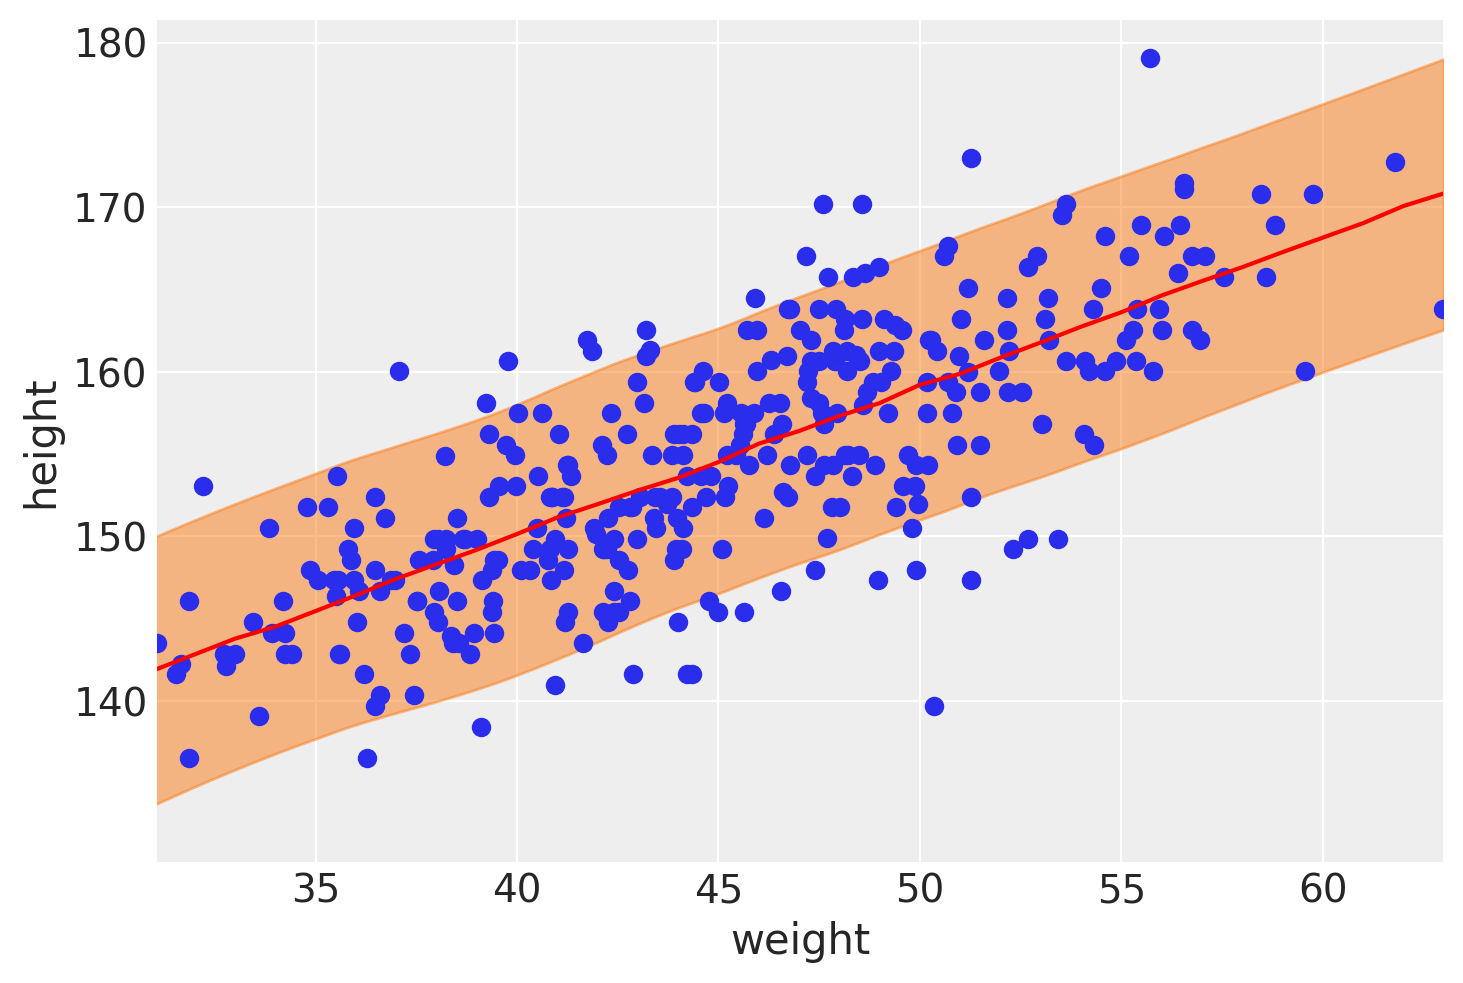

In [34]:
ax = az.plot_hdi(x=x, y=idata_ooo_sims.posterior_predictive['height'], hdi_prob=0.89)
plt.scatter(data_adults.weight, data_adults.height)
plt.plot(x, np.median(prediction_sims, axis=1), "k", color='red')
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(data_adults.weight.min(), data_adults.weight.max());

---